The goal of this notebook is to do two things. 

1) Construct Bellman Sampling
2) Focus on visualizing

## Quadrant Sampling
We will split the network into quadrants and sample the nodes from each quardrant to ensure we have nodes scattered throughout Cambridge. 

In [278]:
# importing the packages
import pandas as pd
import googlemaps
import time
import pandas as pd
import numpy as np
import pickle
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

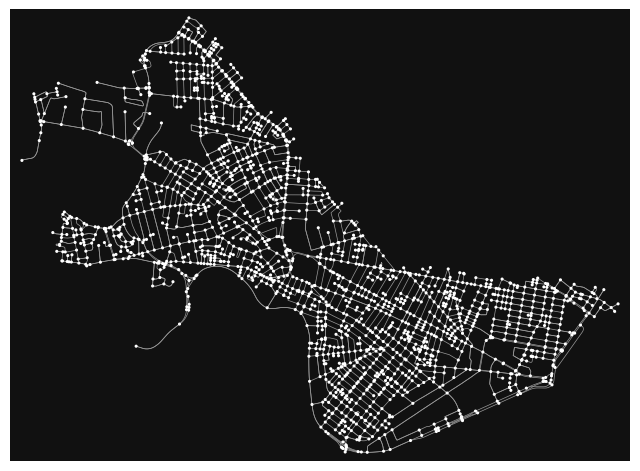

In [310]:
# loading in the data
with open("H_new_graph_2.pkl", 'rb') as f:
    H = pickle.load(f)

cambridge_crime = pd.read_csv("cambridge_crime_with_nodes_final.csv")
distance_matrix = pd.read_csv("distance_matrix_1880.csv", index_col = 0)
nodes_id = list(set(cambridge_crime['closest_node']))
nodes_id_cleaned = [str(id) for id in list(nodes_id)]
cleaned_distance_matrix =  distance_matrix.loc[nodes_id,nodes_id_cleaned]
# 1. Create the first DataFrame: node vs. crime count
# Count the number of crimes mapped to each node
node_crime_counts = cambridge_crime['closest_node'].value_counts().reset_index()
node_crime_counts.columns = ['node_id', 'crime_count']
fig, ax = ox.plot_graph(H, node_size=5, edge_linewidth=0.5)

In [280]:
# dividing the nodes into quadrants
# extracting the latitude and the longitudes from each node along other things
# have info about highway, and info like this
# also filter out the nodes to match the ones we have oin our distance matrix
node_positions = {node: H.nodes[node] for node in [id for id in nodes_id if id in [node for node in H.nodes]]}
node_positions_df = pd.DataFrame.from_dict(node_positions, orient='index')[['lat', 'lon']]
node_positions_df.index.name = 'node_id'
node_positions_df.reset_index(inplace=True)
# node_positions_df

In [281]:
# merge the crime counts with the positions
node_data = pd.merge(node_positions_df, node_crime_counts, how='left', left_on='node_id', right_on='node_id')
# node_data

In [282]:
# Define quadrants based on median latitude and longitude
lat_median = node_data['lat'].median()
lon_median = node_data['lon'].median()

In [283]:
# Assign each node to a quadrant
# how we assign to a quadrant
node_data['quadrant'] = (node_data['lat'] > lat_median).astype(int) * 2 + (node_data['lon'] > lon_median).astype(int)
node_data['quadrant'].value_counts()

quadrant
1    561
2    561
0     80
3     79
Name: count, dtype: int64

In [284]:
# visualize the network with the quadrants 
# assign colors to the qudrants
quadrant_colors = {0:'red', 1:'blue', 2:'green',3:'yellow'}
node_data['color'] = node_data['quadrant'].map(quadrant_colors)
node_color_mapping = node_data.set_index('node_id')['color'].to_dict()

In [285]:
# try filtering the original graph
filtered_H = H.subgraph(node_positions).copy()

In [286]:
for node in filtered_H.nodes:
    filtered_H.nodes[node]['color'] = node_color_mapping[node]

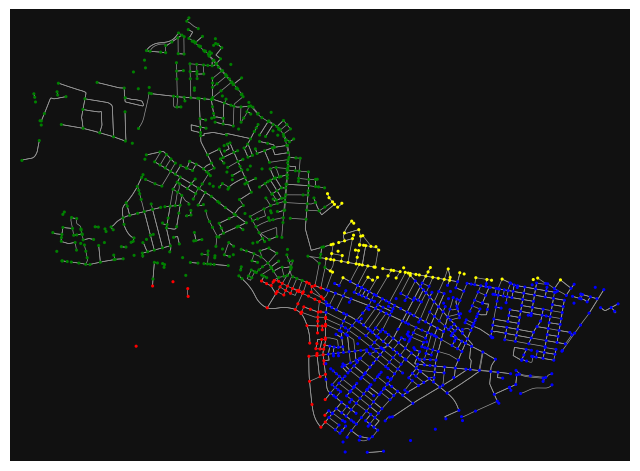

In [287]:
fig, ax = ox.plot_graph(
    filtered_H,
    node_size=5,
    edge_linewidth=0.5,
    node_color=[filtered_H.nodes[node]['color'] for node in filtered_H.nodes]
)

In [301]:
# we will write a function to use multiple times to resemble the network structure
def quadrant_down_sample(total_nodes):
    '''
    This is the function that we will use to downsample and visualize. 
    Parameters:

    Parameters: The number of total nodes that you want to keep
    Returns: All of the new dataframes we need for the optimization problem
    '''
    # print out the original distribution of the nodes 
    quadrant_counts_original = node_data['quadrant'].value_counts()

    # some retarded code I wrote to ensure it acutally adds up to nodes_keep
    # def redundant but who gives a fuck 
    proportional_allocation = (
    quadrant_counts_original / quadrant_counts_original.sum() * total_nodes
    ).astype(int)
    if proportional_allocation.sum() < total_nodes:
        diff = total_nodes - proportional_allocation.sum()
        if diff % 2 == 0:
            amount_to_assign = diff / 2
            proportional_allocation.values[2] += amount_to_assign
            proportional_allocation.values[3] += amount_to_assign
        else:
            proportional_allocation.values[2] += diff 

    # now the downsampling occurs
    # now we actualy downsample
    downsampled_node_data = pd.DataFrame()

    # we then need to make our graph smaller 

    # we will do this randomly
    for quadrant, group in node_data.groupby('quadrant'):
        # grab the proportional size 
        allocated_size = proportional_allocation[quadrant]
        if len(group) > allocated_size:
            # this is where we downsample
            downsampled_group = group.sample(n=allocated_size)
        else:
            downsampled_group = group
        
        downsampled_node_data = pd.concat([downsampled_node_data, downsampled_group], axis =0)
    
    # we have to remake our graph now 
    new_nodes = {node: filtered_H.nodes[node] for node in [id for id in downsampled_node_data['node_id']]}
    new_graph = filtered_H.subgraph(new_nodes).copy()


    # now we need to remake the cambridge_crimes data set 
    # Extract the latitudes and longitudes of the crime locations
    crime_latitudes = cambridge_crime['latitude']
    crime_longitudes = cambridge_crime['longitude']

    # Find the nearest nodes in the graph for each crime location
    crime_closest_nodes = ox.distance.nearest_nodes(new_graph, X=crime_longitudes, Y=crime_latitudes, return_dist=False)

    # Add the closest node as a new column in the crime DataFrame
    cambridge_crime['new_closest_node'] = crime_closest_nodes

    # 1. Create the first DataFrame: node vs. crime count
    # Count the number of crimes mapped to each node
    node_crime_counts = cambridge_crime['new_closest_node'].value_counts().reset_index()
    node_crime_counts.columns = ['node_id', 'crime_count']

    # now we need to filter through the distance matrix and just return this one
    nodes_id = list(set(cambridge_crime['new_closest_node']))
    nodes_id_cleaned = [str(id) for id in list(nodes_id)]
    new_cleaned_distance_matrix =  cleaned_distance_matrix.loc[nodes_id,nodes_id_cleaned]

    # Display the node-crime count DataFrame
    # print("Node-Crime Count DataFrame:")
    # print(node_crime_counts.head())

    # 2. Create the second DataFrame: add closest node to cambridge_crime DataFrame
    # The 'closest_node' column in cambridge_crime already contains this information

    # Display the updated cambridge_crime DataFrame
    # print("Updated Cambridge Crime DataFrame with Closest Node:")
    # print(cambridge_crime.head())
    # node_crime_counts.to_csv("/Users/anderssteiness/Desktop/MIT/MBAn/optimization/Project/node_crime_counts.csv", index=False)

    # cambridge_crime.to_csv("/Users/anderssteiness/Desktop/MIT/MBAn/optimization/Project/cambridge_crime_with_nodes.csv", index=False)
        
    return downsampled_node_data, cambridge_crime, node_crime_counts, new_cleaned_distance_matrix

In [308]:
new_node_data, new_cambridge_crime, new_crime_counts, new_distance_matrix =  quadrant_down_sample(400)

In [311]:
new_distance_matrix

,61323264,61323266,2562504735,2562504741,61329446,61327402,61325357,61333558,61323319,61321284,...,61323235,61327333,61323237,61327337,61327339,61321200,4267069426,61327348,61321207,7067953147
61323264,NaN,40.067,1350.066,1509.435,1150.917,1796.317,1805.864,4484.951,2517.065,3195.354,...,384.961,5276.213,188.486,3412.859,4040.518,5228.082,1865.761,3547.887,4969.179,1576.841
61323266,40.067,NaN,1390.133,1484.342,1190.984,1836.384,1845.931,4525.018,2557.132,3235.421,...,344.894,5316.280,148.419,3452.926,4080.585,5268.149,1905.828,3587.954,5009.246,1616.908
2562504735,1623.677,1610.161,NaN,159.369,906.503,2651.950,2292.337,3393.163,1475.080,2153.369,...,1403.613,4167.613,1461.742,2370.874,2998.533,4119.482,823.776,2505.902,3860.579,2668.964
2562504741,1482.963,1469.447,176.184,NaN,957.268,2511.236,2343.102,3443.928,1525.845,2204.134,...,1262.899,4218.378,1321.028,2421.639,3049.298,4170.247,874.541,2556.667,3911.344,2604.238
61329446,1172.352,1212.419,389.593,548.962,NaN,2719.979,1388.480,3488.975,1521.089,2199.378,...,1241.263,4280.237,1299.392,2416.883,3044.542,4232.106,869.785,2551.911,3973.203,1762.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61321200,5352.335,5338.819,4238.792,4062.608,4256.640,6380.608,5515.238,1288.103,3539.659,2762.999,...,5132.271,397.174,5190.400,2889.942,1963.414,NaN,3759.168,2775.786,557.161,6019.101
4267069426,2157.062,2143.546,1043.519,867.335,1036.979,3185.335,2295.577,2788.364,983.440,1498.767,...,1936.998,3579.626,1995.127,1867.869,2343.931,3531.495,NaN,2002.897,3272.592,2799.440
61327348,3624.651,3611.135,2511.108,2334.924,2504.568,4652.924,3658.142,1617.002,1100.736,594.418,...,3404.587,2451.390,3462.716,135.028,974.777,2822.638,1467.589,NaN,2353.465,4267.029
61321207,5093.455,5079.939,3979.912,3803.728,3997.760,6121.728,5256.358,793.004,3280.779,2383.570,...,4873.391,552.752,4931.520,2510.513,1489.227,557.161,3500.288,2392.247,NaN,5760.221
